In [5]:
##1

# Importing the kaggle dataset
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle
!kaggle datasets download -d yasserhessein/gender-dataset
!unzip gender-dataset.zip -d gender-dataset

Streaming output truncated to the last 5000 lines.
  inflating: gender-dataset/Dataset/Validation/Male/189674.jpg  
  inflating: gender-dataset/Dataset/Validation/Male/189675.jpg  
  inflating: gender-dataset/Dataset/Validation/Male/189676.jpg  
  inflating: gender-dataset/Dataset/Validation/Male/189679.jpg  
  inflating: gender-dataset/Dataset/Validation/Male/189681.jpg  
  inflating: gender-dataset/Dataset/Validation/Male/189684.jpg  
  inflating: gender-dataset/Dataset/Validation/Male/189688.jpg  
  inflating: gender-dataset/Dataset/Validation/Male/189689.jpg  
  inflating: gender-dataset/Dataset/Validation/Male/189691.jpg  
  inflating: gender-dataset/Dataset/Validation/Male/189692.jpg  
  inflating: gender-dataset/Dataset/Validation/Male/189693.jpg  
  inflating: gender-dataset/Dataset/Validation/Male/189694.jpg  
  inflating: gender-dataset/Dataset/Validation/Male/189695.jpg  
  inflating: gender-dataset/Dataset/Validation/Male/189696.jpg  
  inflating: gender-dataset/Dataset/Val

In [6]:
##2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2  # OpenCV for face detection using Haar Cascade
import os # os for managing files and directories

In [7]:
##3

# Paths to the directories
train_female_dir = '/content/gender-dataset/Dataset/Train/Female'
train_male_dir = '/content/gender-dataset/Dataset/Train/Male'
test_female_dir = '/content/gender-dataset/Dataset/Test/Female'
test_male_dir = '/content/gender-dataset/Dataset/Test/Male'

# Set the image size we will use further
img_size = (64, 64)

# Function to load a limited number of images from a directory and label them
def load_images_from_directory(directory, label, img_size, max_images = 6000):
    images = []
    labels = []

    # Iterate through the files in the directory and limit the number of images
    count = 0
    for entry in os.scandir(directory):
        if entry.is_file() and count < max_images:
            img_path = entry.path
            img = cv2.imread(img_path)  # Read the image
            img_resized = cv2.resize(img, img_size)  # Resize the image
            img_resized = img_resized / 255.0  # Normalize the image

            # Add the resized image and corresponding label to the images and labels list we created
            images.append(img_resized)
            labels.append(label)

            count += 1

        elif count >= max_images:
            break # to stop the process when we get the desired number of images

    return np.array(images), np.array(labels)

# Load 6000 training data for both Female and Male
train_female_images, train_female_labels = load_images_from_directory(train_female_dir, 0, img_size, max_images = 6000)
train_male_images, train_male_labels = load_images_from_directory(train_male_dir, 1, img_size, max_images = 6000)

# Load 6000 testing data for both Female and Male
test_female_images, test_female_labels = load_images_from_directory(test_female_dir, 0, img_size, max_images = 6000)
test_male_images, test_male_labels = load_images_from_directory(test_male_dir, 1, img_size, max_images = 6000)

# Combine the male & female images and labels to get a single X_train, y_train, X_test, y_test for entire dataset
X_train = np.concatenate((train_female_images, train_male_images), axis=0)
y_train = np.concatenate((train_female_labels, train_male_labels), axis=0)
X_test = np.concatenate((test_female_images, test_male_images), axis=0)
y_test = np.concatenate((test_female_labels, test_male_labels), axis=0)

# Shuffle the data for no bias while training our model
indices = np.arange(X_train.shape[0]) # Create an array of indices from 0 to 11999
np.random.shuffle(indices) # Shuffle the indices array
X_train = X_train[indices] # Rearrange the train images according to the shuffled indices array
y_train = y_train[indices] # Rearrange the train labels according to the shuffled indices array

# Do the same for test images
indices = np.arange(X_test.shape[0])
np.random.shuffle(indices)
X_test = X_test[indices]
y_test = y_test[indices]

# Print dataset details
print("No. of training examples = ", X_train.shape[0])
print("Size of each image in dataset = ", X_train.shape[1:])
print("No. of test examples = ", X_test.shape[0])

No. of training examples =  12000
Size of each image in dataset =  (64, 64, 3)
No. of test examples =  12000


      Female        Female        Male        Male        Male        

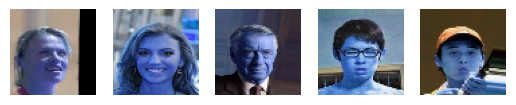

In [8]:
##4

#Let's view some images from our dataset after processing in the previous step

# Choose 5 random indices from the training dataset
index = np.random.choice(X_train.shape[0], 5)

print("   ", end="   ")

# Plot each image and its corresponding label
for i, ind in enumerate(index):
    plt.subplot(1, 5, i+1) # Displays the images in a 1x5 manner i.e. 5 images in a single row
    plt.imshow(X_train[ind])
    plt.axis("off")
    # Display the label (0 for Female, 1 for Male)
    label = "Female" if y_train[ind] == 0 else "Male"
    print(label, end = "        ")

plt.show()

In [9]:
##5

# Let's divide the training data into training and validation data
n_validation = 2000

X_validation = X_train[: n_validation]
y_validation = y_train[: n_validation]

X_train = X_train[n_validation :]
y_train = y_train[n_validation :]
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((10000, 64, 64, 3), (10000,), (2000, 64, 64, 3), (2000,))

In [10]:
##6

# Load the Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_and_crop_faces(images):
    cropped_faces = []
    for img in images:
        # Ensure the image is in uint8 format
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)

        # Convert the image to grayscale for Haar cascade detection
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces in the image
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        if len(faces) == 0:
            # If no face is detected, use the original image
            face_resized = cv2.resize(img, (64, 64))
            cropped_faces.append(face_resized)
        else:
            # Assume the first detected face is the one we want to use
            (x, y, w, h) = faces[0]
            # Crop the image to the face region
            face_img = img[y:y+h, x:x+w]
            # Resize the face image to the required size (64x64)
            face_resized = cv2.resize(face_img, (64, 64))
            cropped_faces.append(face_resized)

    return np.array(cropped_faces)

# Apply Haar cascade on X_train and X_validation
X_train_faces = detect_and_crop_faces(X_train)
X_validation_faces = detect_and_crop_faces(X_validation)

# Now X_train_faces and X_validation_faces contain the cropped face images

In [11]:
##7

# Import the reuired classes from tenserflow to build the CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization)

model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten the feature maps
    Flatten(),

    # Fully Connected Layers
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output layer for binary classification (1 for male, 0 for female)
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
##8

# Compiling
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,307,073 (4.99 MB)

 Trainable params: 1,306,625 (4.98 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
##9

# Training
history = model.fit(X_train, y_train, epochs = 15, batch_size = 32, validation_data=(X_validation, y_validation))

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 127s 390ms/step - accuracy: 0.6851 - loss: 0.8091 - val_accuracy: 0.8315 - val_loss: 0.4883
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 133s 362ms/step - accuracy: 0.9104 - loss: 0.2405 - val_accuracy: 0.9270 - val_loss: 0.2037
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 362ms/step - accuracy: 0.9343 - loss: 0.1700 - val_accuracy: 0.8975 - val_loss: 0.2442
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 353ms/step - accuracy: 0.9481 - loss: 0.1409 - val_accuracy: 0.9440 - val_loss: 0.1437
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 146s 365ms/step - accuracy: 0.9560 - loss: 0.1165 - val_accuracy: 0.9530 - val_loss: 0.1417
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 365ms/step - accuracy: 0.9705 - loss: 0.0891 - val_accuracy: 0.9355 - val_loss: 0.1740
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 367ms/step - accuracy: 0.9695 - loss: 0.0840 - val_accuracy: 0.9535 - val_loss: 0.1326
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 357ms/step - accuracy: 0.9796 -

In [15]:
##10

# Let's save this trained and compiled model so that we can use it for live detection
model.save('gender_model.h5')

In [16]:
##11

# Let's check how effective our model is on test data
results = model.evaluate(X_test, y_test)
print("Loss = ", results[0])
print("Accuracy = ", results[1]*100, "%")

375/375 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.9518 - loss: 0.1687
Loss =  0.15881824493408203
Accuracy =  95.3083336353302 %


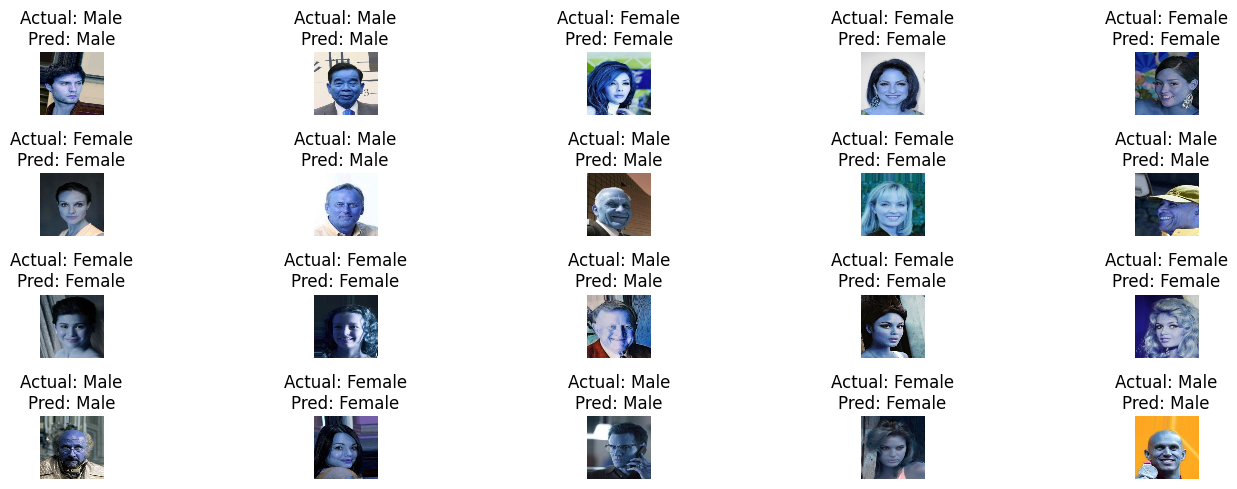

In [18]:
##12

# Let's test the model on the images from our test dataset

# Number of predictions we want to see
n = 20

# Choose n random indices from the test dataset
index = np.random.choice(X_test.shape[0], n)

# Adjust the figure size for better visibility
plt.figure(figsize=(15, 5))

for i, ind in enumerate(index):
    plt.subplot(4, 5, i + 1)  # 4 rows and 5 columns for 20 predictions (as required by mentors)
    plt.imshow(X_test[ind])
    plt.axis("off")

    # 0 implies Female, 1 implies Male in our model
    actual_label = "Female" if y_test[ind] == 0 else "Male"

    # Reshape the image for prediction (1, 64, 64, 3)
    image = X_test[ind].reshape(1, 64, 64, 3)
    prediction = model.predict(image, verbose=0)

    # prediction is a probability value between 0 and 1, convert it to label accordingly
    predicted_label = "Female" if prediction[0][0] < 0.5 else "Male"

    # Display both actual and predicted labels as the title
    plt.title(f"Actual: {actual_label}\nPred: {predicted_label}")
    #plt.title helps us with aligning the labels so that they are present exactly in the middle of each image

plt.tight_layout() # Helps avoid overlap of predicted labels with image above them
plt.show()

We got all the predictions correct for this random set of 20 images from test dataset.

In [19]:
##13

# Let's create a function which takes image path as input and gives the predicted gender as output
# We will also create a box around the detected face using haar cascade
# This will also help us in building a live webcam gender detection tool

from tensorflow.keras.models import load_model

# Name our compiled and trained model as 'model' for further use
model = load_model('gender_model.h5')

def predict_gender(image_path):
    # Load the image using OpenCV
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Unable to load the image. Check the file path.")
        return None

    # Convert the image to grayscale for Haar cascade detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Let's bring in Haar Cascade again, but this time we will also draw a bo around the face in the image
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No faces detected.")
        return None

    # Draw a rectangle around each detected face
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Assume the first detected face is the one we want to use for gender prediction
    (x, y, w, h) = faces[0]

    # Crop the image to the face region
    face_img = img[y:y+h, x:x+w]

    # Resize the face image to the required size (64x64)
    face_resized = cv2.resize(face_img, (64, 64))

    # Normalize the image (scaling pixel values to [0, 1])
    face_normalized = face_resized / 255.0

    # Reshape the image to match the input shape of the model (1, 64, 64, 3)
    face_input = np.expand_dims(face_normalized, axis=0)

    # Predict the gender using the model
    prediction = model.predict(face_input, verbose=0)

    # prediction is a probability value, so convert it to gender accordingly
    predicted_label = "Female" if prediction[0][0] < 0.5 else "Male"

    # Display the image with the predicted label
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

    return predicted_label

Run the cell code below to upload custom images to the colab environment. You can run it multiple times, click on upload files and select the files from your computer to upload them.

In [21]:
##14

files.upload()

Saving testjpg.jpeg to testjpg.jpeg


{'testjpg.jpeg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x12\x13\x12\x15\x13\x12\x12\x15\x16\x15\x16\x15\x17\x18\x17\x17\x15\x15\x15\x15\x17\x16\x15\x15\x15\x18\x16\x16\x17\x15\x18\x18\x1d( \x18\x1a%\x1d\x15\x16!1"%)+...\x17\x1f383-7(-.+\x01\n\n\n\x0e\r\x0e\x1b\x10\x10\x1a-%\x1f%----------------+-----------------------------+--7\xff\xc0\x00\x11\x08\x00\xe1\x00\xe1\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x01\x05\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x02\x03\x05\x06\x01\x07\xff\xc4\x00B\x10\x00\x01\x03\x01\x05\x05\x06\x04\x03\x05\x07\x04\x03\x00\x00\x00\x01\x00\x02\x11\x03\x04\x12!1Q\x05Aaq\x81\x06"\x91\xa1\xb1\xf0\x132\xc1\xd1b\xe1\xf1\x14#Rr\x82\x073B\x92\xa2\xb2\xc2\x154Cs\x16S\xd2\xff\xc4\x00\x19\x01\x00\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x04\x01\x00\x05\xff\xc4\x00)\x11\x00\x02\x02\x02\x02\x01\x05\x00\x01\x04\x03\x00\x00\x00\x00\x00\x00\x01\x02\x11

Enter the path of your image in the path_list given below and run the code cell to get the predictions for each of those images.  
Make sure you enter the path within " ".

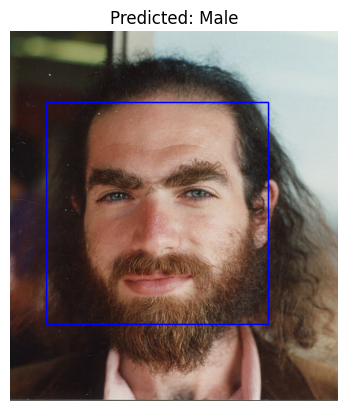

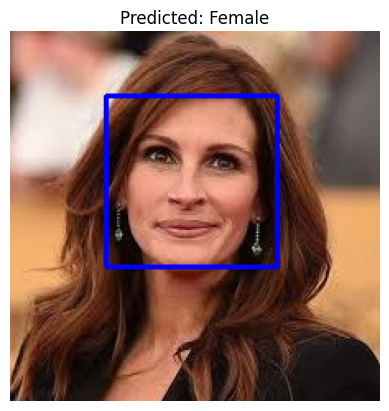

In [22]:
##15

path_list = ["/content/Grigori_Perelman,_1993_(re-scanned)_(cropped).jpg",
             "/content/testjpg.jpeg"
              ]

# Define n as the length of the list
n = len(path_list)

# Iterate over the path_list and call the predict_gender function
for i in range(n):
    predict_gender(path_list[i])

To use 'Gender detection using live-captured image' feature, run the code cell below. A pop-up will ask for permission to use your webcam, allow it to do so. You may have to run the same code cell once more after granting the permission to start with the live video.  
You will see a 'Capture' button above your video. Whenever you want to capture the image you want to use for gender detection, click on that button.

<IPython.core.display.Javascript object>

Saved to photo.jpg


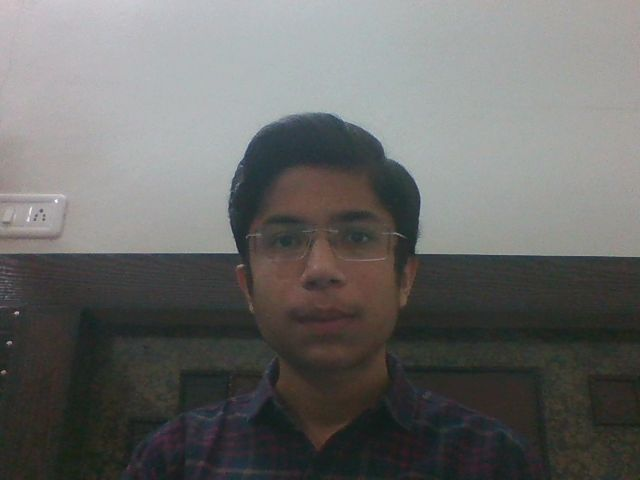

In [44]:
##16

# We have a function that will predict the gender given the image path
# We can build a live gender prediction model if we can get the path of the image captured on live video
# The function take_photo will do exactly what we want!
# Understanding the working of this function is beyond the scope of this project

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode


def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  #show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Your image was captured! You can see it above. If you want to capture a new image, run the previous code cell once again and click the 'Capture' button to capture a new image.  
Once you can see the desired image above, just run the code cell below to see your predicted gender.

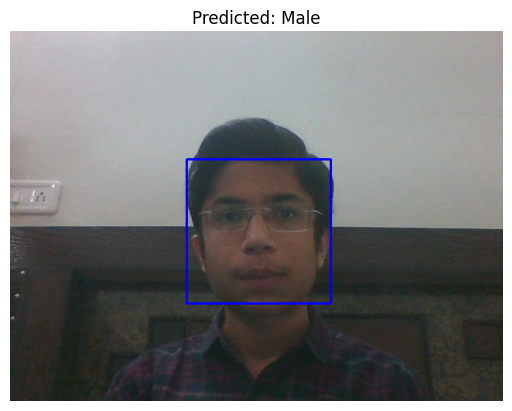

'Male'

In [45]:
 ##14

 # Call our predict_gender function with the path of the image we just captured
 predict_gender("/content/photo.jpg")